Best parameters for descriptor-only model:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


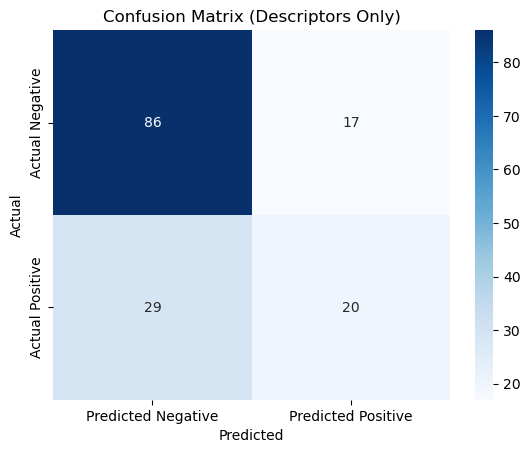

Classification Report (Descriptors Only):
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       103
           1       0.54      0.41      0.47        49

    accuracy                           0.70       152
   macro avg       0.64      0.62      0.63       152
weighted avg       0.68      0.70      0.68       152

Test Set AUC: 0.74
Test Set Log Loss: 0.54


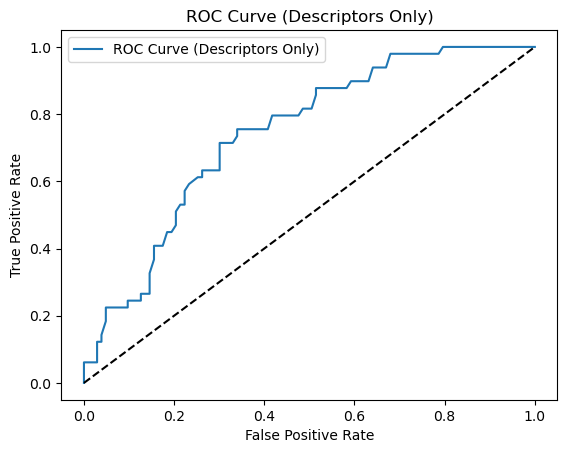

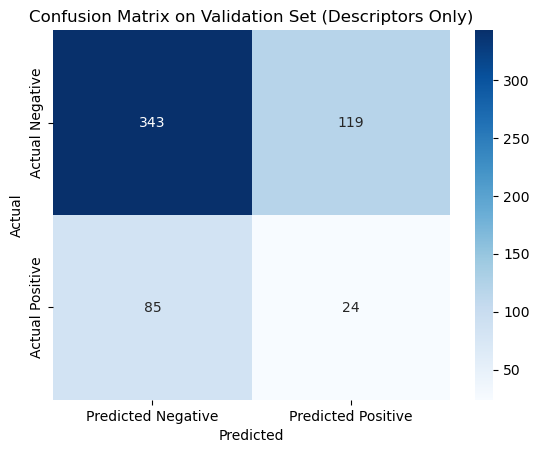

Classification Report on Validation Set (Descriptors Only):
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       462
           1       0.17      0.22      0.19       109

    accuracy                           0.64       571
   macro avg       0.48      0.48      0.48       571
weighted avg       0.68      0.64      0.66       571

Validation Set AUC: 0.52
Validation Set Log Loss: 0.62


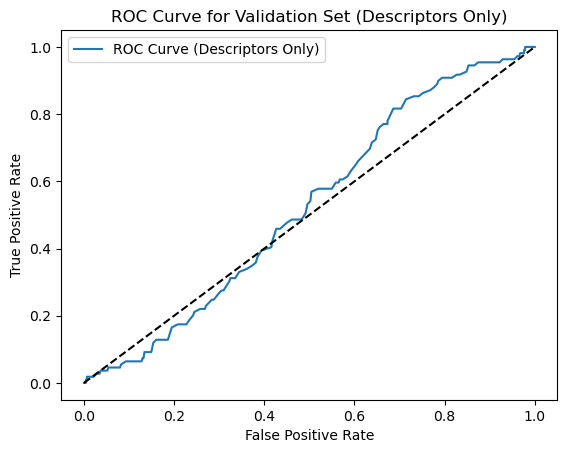

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import PandasTools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load SDF file and convert to DataFrame
sdf_file = "Structures_759_training.sdf"  
df = PandasTools.LoadSDF(sdf_file, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# List of selected descriptors
selected_columns = [
    'r_qp_mol_MW', 'r_qp_volume', 'r_qp_SASA', 'r_qp_PSA',
    'r_qp_QPlogS', 'r_qp_CIQPlogS', 'r_qp_QPlogPoct', 'r_qp_QPlogPo/w',
    'r_qp_dipole', 'r_qp_donorHB', 'r_qp_accptHB',
    'r_qp_QPPCaco', 'r_qp_QPlogBB', 'i_qp_HumanOralAbsorption',
    'r_qp_PercentHumanOralAbsorption', 'r_qp_QPlogHERG',
    'r_qp_IP(eV)', 'r_qp_EA(eV)',
    'i_qp_#stars', 'i_qp_#rotor', 'i_qp_RuleOfFive', 'i_qp_RuleOfThree', 'i_qp_#NandO'
]

# Extract and standardize descriptor features
features = df[selected_columns].fillna(0)
features.columns = features.columns.astype(str)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA to descriptors (adjust components as needed)
pca = PCA(n_components=9)
principal_components = pca.fit_transform(scaled_features)

# Extract the target variable 'Stable'
target_column = 'Stable'
labels = df[target_column].astype(int)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    principal_components, labels, test_size=0.2, random_state=42
)

# Hyperparameter optimization for Random Forest
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100,  
cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Fit the model on training data
random_search.fit(X_train, y_train)
print("Best parameters for descriptor-only model: ", random_search.best_params_)

best_rf_model = random_search.best_estimator_

# Evaluate on the test set
y_pred = best_rf_model.predict(X_test)
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Descriptors Only)')
plt.show()

print("Classification Report (Descriptors Only):")
print(classification_report(y_test, y_pred))

# AUC and Log Loss for Test Set
auc_score = roc_auc_score(y_test, y_prob)
print(f"Test Set AUC: {auc_score:.2f}")
logloss = log_loss(y_test, y_prob)
print(f"Test Set Log Loss: {logloss:.2f}")

# ROC Curve for Test Set
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC Curve (Descriptors Only)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Descriptors Only)')
plt.legend()
plt.show()

# Validation dataset loading
sdf_file_unseen = "Structures_test_571.sdf"  
df_validation = PandasTools.LoadSDF(sdf_file_unseen, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# Prepare features for validation
features_validation = df_validation[selected_columns].fillna(0)
features_validation.columns = features_validation.columns.astype(str)
scaled_features_validation = scaler.transform(features_validation)

# Apply PCA to validation features
principal_components_validation = pca.transform(scaled_features_validation)

# Extract validation labels
labels_validation = df_validation[target_column].astype(int)

# Evaluate on validation set
y_pred_validation = best_rf_model.predict(principal_components_validation)
y_prob_validation = best_rf_model.predict_proba(principal_components_validation)[:, 1]

# Confusion Matrix for validation predictions
cm_validation = confusion_matrix(labels_validation, y_pred_validation)
sns.heatmap(cm_validation, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix on Validation Set (Descriptors Only)')
plt.show()

# Classification Report for the validation set
print("Classification Report on Validation Set (Descriptors Only):")
print(classification_report(labels_validation, y_pred_validation))

# AUC and Log Loss for the Validation Set
auc_score_validation = roc_auc_score(labels_validation, y_prob_validation)
print(f"Validation Set AUC: {auc_score_validation:.2f}")
logloss_validation = log_loss(labels_validation, y_prob_validation)
print(f"Validation Set Log Loss: {logloss_validation:.2f}")

# ROC Curve for Validation Set
fpr_val, tpr_val, _ = roc_curve(labels_validation, y_prob_validation)
plt.plot(fpr_val, tpr_val, label='ROC Curve (Descriptors Only)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Set (Descriptors Only)')
plt.legend()
plt.show()